In [2]:
from SimPEG import Mesh, Utils, Maps
import simpegSP as SP
from pymatsolver import PardisoSolver
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
dx = 10.
npad = 5
hxind = [(dx, npad, -1.3), (dx, 20), (dx, npad, 1.3)]
hyind = [(dx, npad, -1.3), (dx, 20), (dx, npad, 1.3)]
hzind = [(dx, npad, -1.3), (dx, 15), (dx/2., 5)]
mesh = Mesh.TensorMesh([hxind, hyind, hzind], "CCN")
sigma = np.ones(mesh.nC)*1./100.
actind = mesh.gridCC[:,2] < -0.2
actMap = Maps.InjectActiveCells(mesh, actind, 0.)

In [4]:
x = mesh.vectorCCx[np.logical_and(mesh.vectorCCx>-80, mesh.vectorCCx<80.)]
y = mesh.vectorCCy[np.logical_and(mesh.vectorCCy>-80, mesh.vectorCCy<80.)]
# xyzM = Utils.ndgrid(np.ones_like(x)*-80, np.ones_like(y)*-80, np.r_[0.])
xyzM = Utils.ndgrid(x+dx, y, np.r_[0.])
xyzN = Utils.ndgrid(x, y, np.r_[0.])

In [5]:
Maps.IdentityMap(mesh)

In [6]:
wires = Maps.Wires(('jsx', mesh.nC), ('jsy', mesh.nC), ('jsz', mesh.nC))
prb = SP.Problem_CC(mesh, sigma=sigma, jsxMap=wires.jsx, jsyMap=wires.jsy, jszMap=wires.jsz, Solver=PardisoSolver)
rx = SP.Rx.Dipole(xyzN, xyzM)
src = SP.Src.StreamingCurrents([rx], L=np.ones(mesh.nC), mesh=mesh, modelType="CurrentDensity")
survey = SP.Survey([src])
survey.pair(prb)

In [7]:
# prb.jsxDeriv.shape

In [8]:
import scipy.sparse as sp
# temp = sp.vstack((prb.jsxDeriv, prb.jsyDeriv, prb.jszDeriv))

In [9]:
prb.mesh.aveF2CCV.T.shape

(69900, 67500)

In [10]:
# prb.jsxDeriv.shape

In [11]:
print mesh.nC

22500


In [12]:
print mesh.nC * 3

67500


In [13]:
p0 = np.r_[-50, -10., -50.]
p1 = np.r_[50, 10., -100.]
inds = Utils.ModelBuilder.getIndicesBlock(p0, p1, mesh.gridCC)
jsx = np.zeros(mesh.nC)
jsy = np.zeros(mesh.nC)
jsz = np.zeros(mesh.nC)
jsx[inds] = 1.
jsCC = np.r_[jsx, jsy, jsz]

In [14]:
# mesh.plotSlice(jsx, normal="Y")

In [15]:
q = np.zeros(mesh.nC)
inda = Utils.closestPoints(mesh, np.r_[-80, 0., -40])
indb = Utils.closestPoints(mesh, np.r_[80, 0.,  -40])
indc = Utils.closestPoints(mesh, np.r_[0, -80., -40])
indd = Utils.closestPoints(mesh, np.r_[0, 80,  -40])

q[inda] = 1.
q[indb] = -1.
q[indc] = 1.
q[indd] = -1.
f = prb.fields(jsCC)
out = survey.dpred(jsCC, f=f)

In [16]:
# v = np.ones(mesh.nC)[actind]
# jvec = prb.Jvec(q[actind], q[actind])
# jtvec = prb.Jtvec(q[actind], np.ones_like(out))

In [17]:
# mesh.plotSlice(actMap*jtvec, normal="Z", ind=5)

(<matplotlib.collections.QuadMesh at 0x117a60590>,)

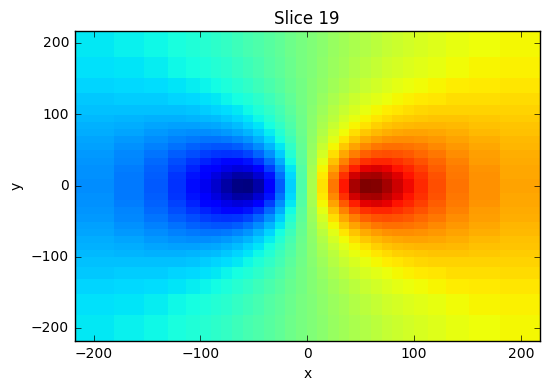

In [18]:
mesh.plotSlice(f[src, 'phi'], normal="Z", ind=19)

In [19]:
prb.jsxDeriv.shape

(22500, 67500)

In [20]:
# Utils.plot2Ddata(xyzN[:,:2], dobs, scale="linear")
# # plt.plot(mesh.gridCC[inda,0], mesh.gridCC[inda,1], 'ko')
# # plt.plot(mesh.gridCC[indb,0], mesh.gridCC[indb,1], 'ro')

In [21]:
# hout = hist(np.log10(abs(dobs)),bins=100)

In [22]:
# print abs(dobs).min()
# print abs(dobs).max()*0.01

In [23]:
depthweight = 1./ ((abs(mesh.gridCC[:,2])+2.5)**3.)
depthweight /= depthweight.max()

In [24]:
# # Generate Full sensitivity
# I = np.diag(np.ones_like(dobs))
# J = np.zeros((dobs.size, mesh.nC))
# for i in range(dobs.size):
#     J[i,:] = prb.Jtvec(sigma, I[:,i])
#     JtJ = (J**2).sum(axis=0)
# JtJ /= JtJ.max()
# prb.G = J

In [25]:
# out = mesh.plotSlice(JtJ, normal="Y", ind=12)
# plt.colorbar(out[0])

In [26]:
# plt.plot(1./dmisfit.Wd.diagonal())

In [27]:
from SimPEG.EM.Static.SIP.Regularization import MultiRegularization

In [28]:
dobs = survey.dpred(jsCC)
dobs+= np.random.randn(survey.nD)*abs(dobs).max() * 0.05

In [40]:
from SimPEG import (Mesh, Maps, Utils, DataMisfit, Regularization,
                    Optimization, Inversion, InvProblem, Directives)
survey.std = 0.
survey.eps = abs(dobs).max() * 0.05
survey.dobs = dobs
 
dmisfit = DataMisfit.l2_DataMisfit(survey)
regmap = Maps.IdentityMap(nP = mesh.nC*3)
reg = MultiRegularization(mesh, mapping=regmap ,nModels=3)
reg.cell_weights = depthweight
reg.alpha_s = 1.
reg.alpha_x = 1.
reg.alpha_y = 1.
reg.alpha_z = 1.
opt = Optimization.InexactGaussNewton(maxIter=100, tolX=1e-20, tolF=1e-20)
opt.maxIterLS = 20
IRLS = Directives.Update_IRLS(norms=([0.,1.,1.,1.]),
                                     eps=None, f_min_change=1e-3,
                                     minGNiter=3)
# senseweight = Directives.Update_Wj()
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
target = Directives.TargetMisfit()
# Create an inversion object
beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=3)
betaest = Directives.BetaEstimate_ByEig()
betaest.beta0_ratio = 1e3
# updateprecond = Directives.Update_lin_PreCond()
# inv = Inversion.BaseInversion(invProb, directiveList=[betaest, updateprecond, IRLS])
inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, target])
prb.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
m0 = np.ones(mesh.nC*3)*0.
reg.mref = m0
mopt = inv.run(m0)

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.29e+03  1.42e+04  0.00e+00  1.42e+04    9.46e+04      0              
   1  6.29e+03  8.52e+02  9.00e-02  1.42e+03    1.50e+04      0              
   2  6.29e+03  4.70e+02  1.02e-01  1.11e+03    4.91e+03      0              
   3  1.26e+03  4.03e+02  1.10e-01  5.41e+02    7.89e+03      0              
   4  1.26e+03  1.87e+02  1.71e-01  4.02e+02    4.40e+03      0              
   5  1.26e+03  1.65e+02  1.79e-01  3.90e+02    3.78e+03      0              
   6  2.52e+02  1.58e+02  1.80e-01  2.04e+02    5.34e+03      0              
   7  2.52e+02  1.45e+02  1.99e

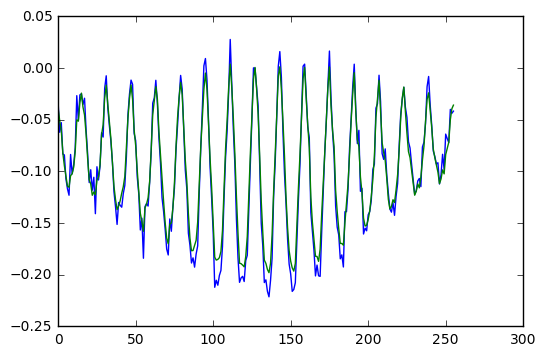

In [41]:
plt.plot(dobs)
plt.plot(invProb.dpred)

In [42]:
prb.jsxDeriv.shape

(22500, 67500)

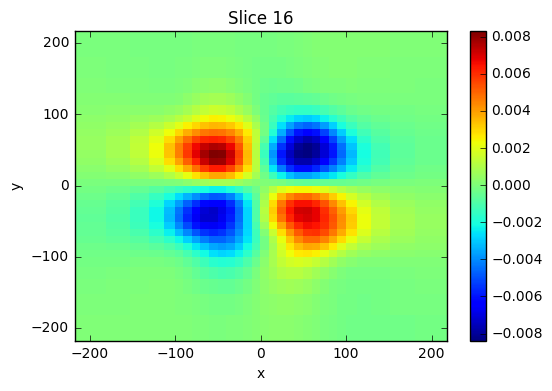

In [43]:
out = mesh.plotSlice(mopt[mesh.nC:mesh.nC*2], ind=16)
plt.colorbar(out[0])

In [44]:
print mesh

  ---- 3-D TensorMesh ----  
   x0: -217.56
   y0: -217.56
   z0: -292.56
  nCx: 30
  nCy: 30
  nCz: 25
   hx: 37.13, 28.56, 21.97, 16.90, 13.00, 20*10.00, 13.00, 16.90, 21.97, 28.56, 37.13
   hy: 37.13, 28.56, 21.97, 16.90, 13.00, 20*10.00, 13.00, 16.90, 21.97, 28.56, 37.13
   hz: 37.13, 28.56, 21.97, 16.90, 13.00, 15*10.00, 5*5.00


In [45]:
temp = out[0]

In [46]:
temp.colorbar.vmin

-0.0083757912098289655

-120.0


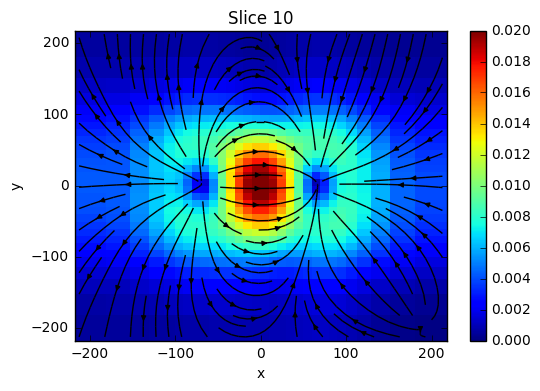

In [47]:
indz = 10
print mesh.vectorCCz[indz]
out = mesh.plotSlice(mopt, view='vec', vType="CCv", ind=indz, clim=(0, 0.02))
cb = plt.colorbar(out[0])

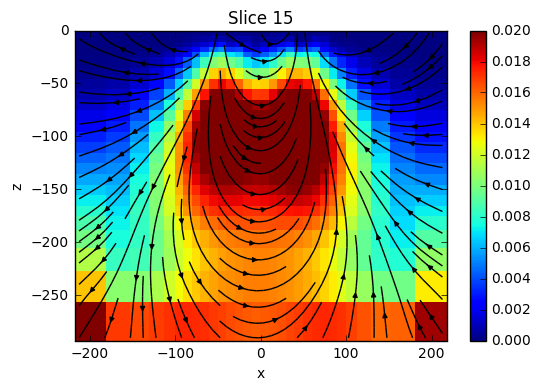

In [48]:
mesh.plotSlice(mopt, view='vec', vType="CCv", normal="Y", clim=(0, 0.02))
plt.colorbar(out[0])

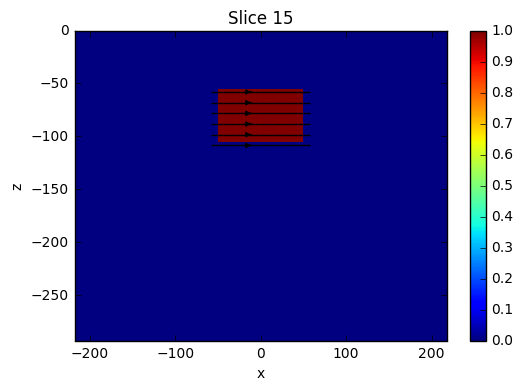

In [49]:
out = mesh.plotSlice(jsCC, view='vec', vType="CCv", normal="Y")
plt.colorbar(out[0])

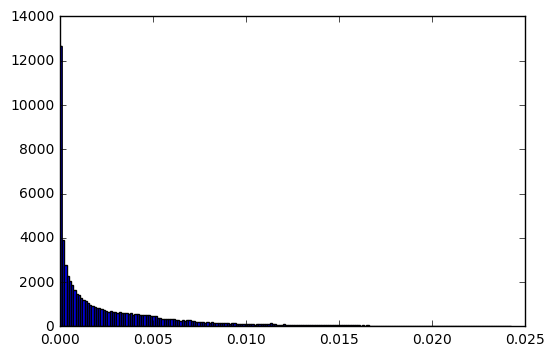

In [50]:
hout = hist(abs(mopt), bins=200)
# plt.xlim(0, 0.008)
plt.xscale("linear")

(<matplotlib.contour.QuadContourSet at 0x14fa21fd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x137608e90>)

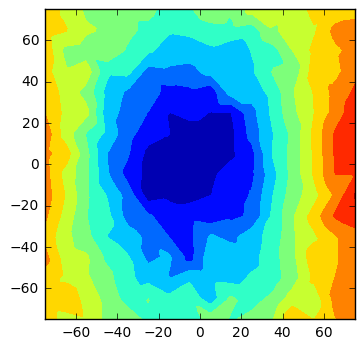

In [51]:
Utils.plot2Ddata(xyzN[:,:2], survey.dobs, scale="linear")

(<matplotlib.contour.QuadContourSet at 0x14fb0f050>,
 <matplotlib.axes._subplots.AxesSubplot at 0x14fa8a090>)

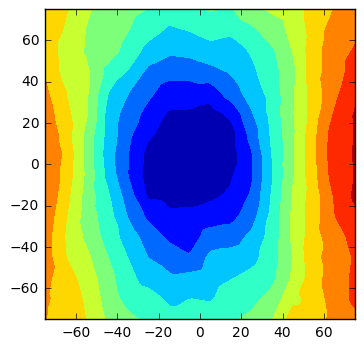

In [52]:
Utils.plot2Ddata(xyzN[:,:2], invProb.dpred, scale="linear")